In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping to/from integers
# chars = 
# stoi =
# itos =
# vocab_size =

chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars,1)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


# chars = sorted(list(set(''.join(words))))
# stoi = {s:i+1 for i,s in enumerate(chars)}
# stoi['.'] = 0
# itos = {i+1:s for i,s in enumerate(chars)}
# itos[0] = '.'
# vocab_size = len(itos)


print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset 
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([205280, 3]) torch.Size([205280])
torch.Size([22866, 3]) torch.Size([22866])


In [71]:
# MPL revisited
n_embd = 10  # the dimensionality of the character embedding vector
n_hidden = 200  # the number of neurons in the hidden layer of the MPL

g  = torch.Generator().manual_seed(2147483647)  # for reproductibility
C  = torch.randn((vocab_size, n_embd),            generator= g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator= g) * ((5 / 3) / ( (n_embd * block_size)**0.5 ) )  #0.2    #so that matrix multiplication for one sample becomes sum(features * weights)
b1 = torch.randn(n_hidden,                        generator= g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),           generator= g) * 0.01   #why not 0?
b2 = torch.randn(vocab_size,                      generator= g) * 0      #at initiallization

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # no. of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [53]:
torch.randn(1000).std()

tensor(0.9952)

tensor(0.0143) tensor(1.0043)
tensor(0.0026) tensor(1.0133)


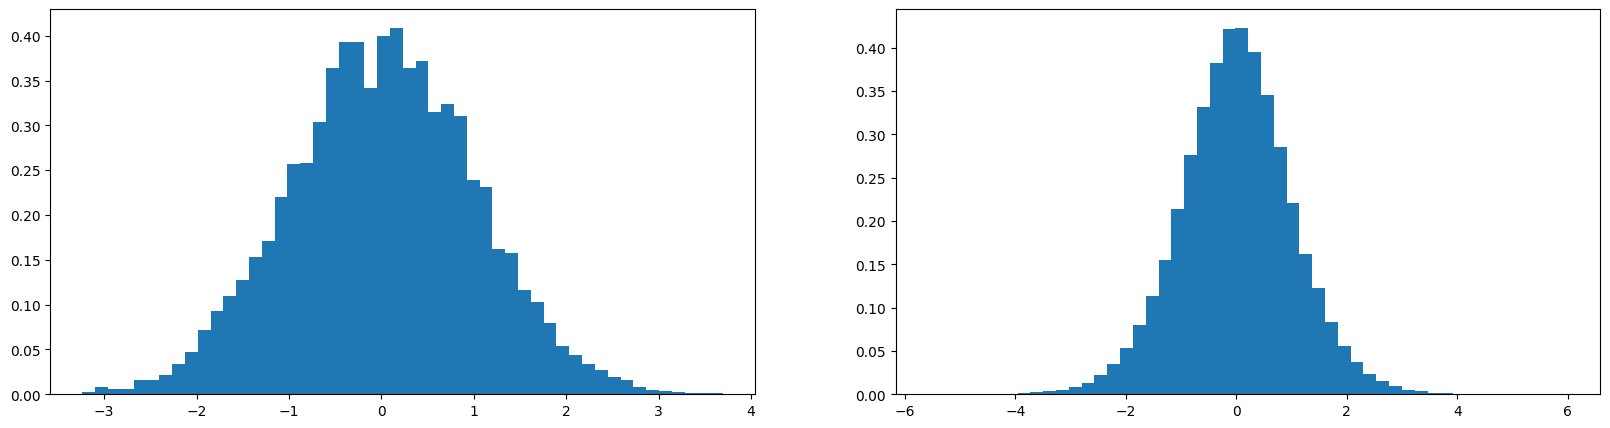

In [70]:
tan_std = (5 / 3) / (10**0.5)  #for tanh
std = 1 / 10**0.5

x = torch.randn(1000, 10)
w = torch.randn(10, 200) * std   # / 10**0.5 #square root of fan_in
y = x @ w
t = torch.tanh(y)
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [72]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  #batch X,Y

    #forward pass
    emb = C[Xb]  #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  #concatenate the vetors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decav
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:   #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


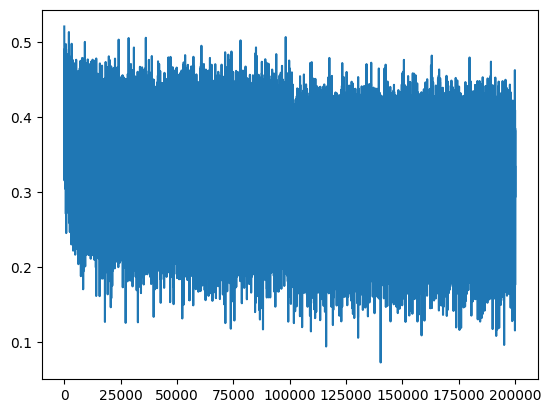

In [10]:
plt.plot(lossi)

In [73]:
@torch.no_grad()  #this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte),
    }[split]
    emb = C[x]   #(samples, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  #concat into (samples, block_size*n_embd)
    h = torch.tanh(embcat @ W1 + b1)  #(samples, n_hidden)
    logits = h @ W2 + b2  #(samples, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.0453150272369385


In [74]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        #forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  #decode and print the generated word

carmahzaylyn.
kiffinleige.
tyrencessa.
jazon.
nadelynn.
jareei.
nellara.
chaiivan.
legyn.
ham.
joce.
quint.
salin.
alianni.
waveron.
jaryxin.
kaellissa.
med.
edi.
abette.


In [26]:
h
#so tanh what it do is squeeze the data in range of -1 to 1
#we are seeing so many values of -1 and 1
#lets see through plt

tensor([[ 0.5503, -0.1064, -0.6658,  ..., -0.3477, -0.9756,  0.8880],
        [-0.9081, -0.1924, -0.1833,  ...,  0.0494,  0.4942,  0.4397],
        [ 0.8016,  0.1173,  0.8237,  ...,  0.2890,  0.6476,  0.8827],
        ...,
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849],
        [-0.9362,  0.0930, -0.2810,  ..., -0.1260,  0.7874,  0.9102],
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849]],
       grad_fn=<TanhBackward0>)

In [27]:
h.shape

torch.Size([32, 200])

In [28]:
h.view(-1).shape

torch.Size([6400])

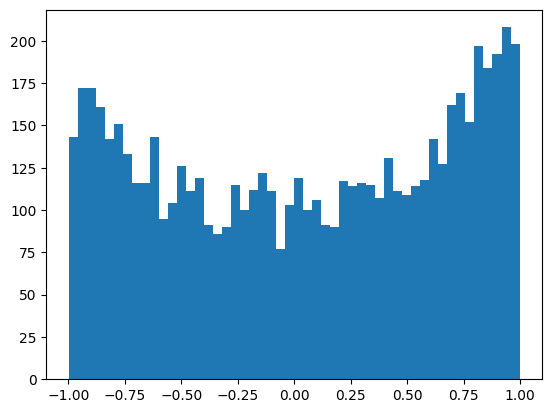

In [29]:
plt.hist(h.view(-1).tolist(), 50);
# it is a problem because we know the graph of tanh flatterns at -1 & 1
# also you can see from grad formula = 1-tanh**2, which makes grad = 0
# which means it didn't backpropogate -> it stops back propogating
# which makes the grad = 0 and never improving or learning
# that makes the dead neurons and a permanent brain damage
# and which mean their is is less trainnig for those neurons 
# bcz they update less frequently
# not good specially at initiallization
# also it is a problem of scaling and wide range
# we found in main code -> hpreact = embcat @ W1 + b1
# and here W1 and b1 is causing the issue
# so we want this reactivation closer to zero
# not exactly zero , sometimes it is improves little bit optimization
# so that their is like a little bit variation and diversity in the original initiallization of neurons

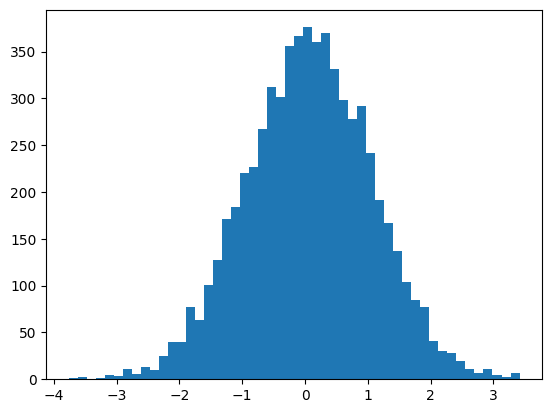

In [30]:
# so let see why that is
# so we can see that the distribution of pre-activations is very very broad
plt.hist(hpreact.view(-1).tolist(), 50);

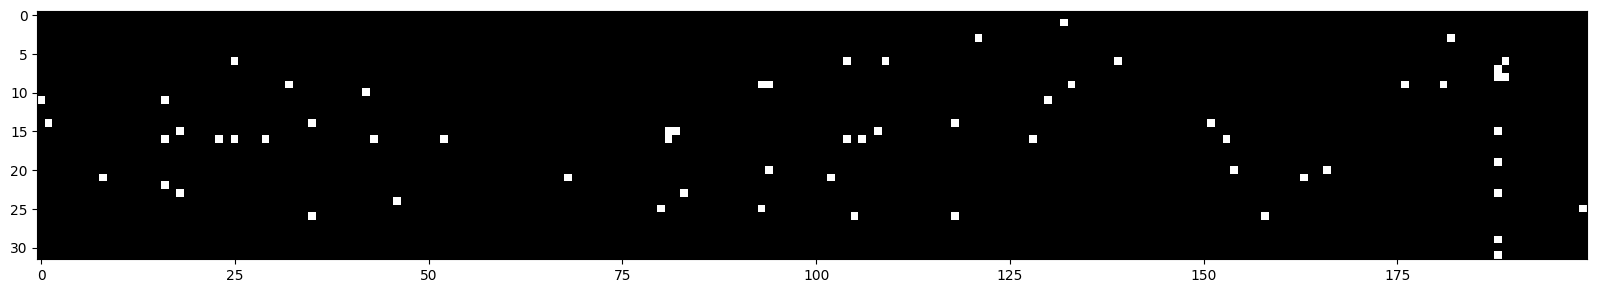

In [31]:
plt.figure(figsize=(20,10))
plt.show(plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest'))
# it is showing how many neurons are dead which is too many
# white -> dead neurons

In [32]:
logits[0]
#range is big  #loss at initialization is much

tensor([-0.0520,  0.2187, -0.0580,  0.0312,  0.1025, -0.0286, -0.0252, -0.0039,
        -0.0014,  0.0656,  0.1515, -0.0458,  0.0007, -0.1682, -0.0619,  0.0301,
        -0.0081, -0.1277, -0.2113, -0.0170,  0.1389,  0.1154,  0.1041, -0.0911,
        -0.1418,  0.1026,  0.0999], grad_fn=<SelectBackward0>)

In [33]:
# 4-dimensional example of the issue
#logits = torch.tensor([0.0,0.0,0.0,0.0]) normally distributed #loss-> 0.25
# also randn is normally distributed like this 
# but what if we scale it by multiplying or adding 
# it increases the range of logit 
logits = torch.randn(4) * 10  
# we found in main code logits = h @ W2 + b2
# and here b2 and W2 is found out to be responsible for scaling
# so we need to initiallize them as small as possible
# so we should do b2 = 0 at initiallization
# and W2 as small possible not exactly zero
# so that the loss will come more close to normalize distribution (-torch.tensor(1/27.0).log())
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([14.3245,  0.3374,  3.3011,  3.9548]),
 tensor([9.9995e-01, 8.4227e-07, 1.6315e-05, 3.1367e-05]),
 tensor(11.0234))

In [34]:
# at initiallizaation we expect much less loss or u can say noramlly distributed loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [69]:
# import matplotlib
# print(matplotlib.get_backend())